<br>

---

# Linear Classification using Tensorflow

---
<br>

<br>

---

## 1.0 - Import Modules

---
<br>

In [5]:
# If any of the modules are not working, simply run pip install on them

from __future__ import absolute_import, division, print_function, unicode_literals

# Supporting modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

# Tensorflow compatibility
import tensorflow.compat.v2.feature_column as fc

# Tensorflow itself
import tensorflow as tf

<br>

---

## 2.0 - Loading Dataset

---
<br>

In [6]:
# Data is loaded from online source. Read into pandas Dataframe
data_train = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')   # Training Data
data_test = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')     # Testing Data

y_train = data_train.pop('survived')      # Training Label - Whether passenger survived?
y_test = data_test.pop('survived')        # Test Label

In [8]:
# Look at the shape of our data
print(data_train.shape)              # 627 rows with 9 columns
print(data_test.shape)               # 264 rows with 9 columns

(627, 9)
(264, 9)


In [9]:
# First 5 rows of our data
data_train.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [10]:
# Information about each columns in our data
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB


<br>

---

## 3.0 - Visualizing Data

---
<br>

<AxesSubplot:>

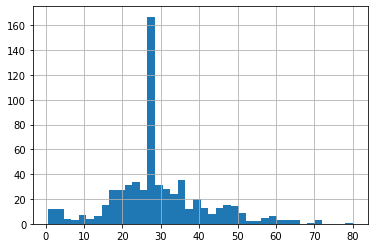

In [11]:
data_train.age.hist(bins=40)            # Take a look at age distributions

<AxesSubplot:>

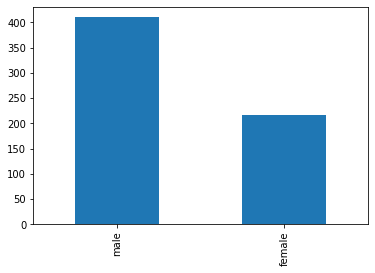

In [12]:
data_train.sex.value_counts().plot(kind='bar')         # Take a look at gender distribution

<AxesSubplot:>

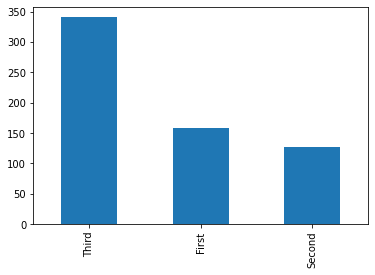

In [13]:
data_train['class'].value_counts().plot(kind='bar')        # Take a look at classes distribution

<AxesSubplot:xlabel='survival %'>

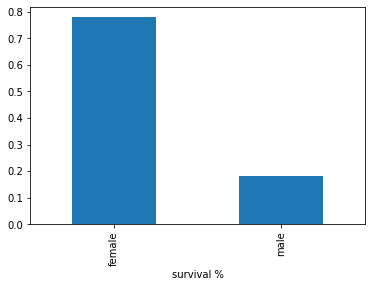

In [14]:
survival_by_gender = pd.concat([ data_train, y_train ], axis=1).groupby('sex').survived.mean().plot(kind='bar')
survival_by_gender.set_xlabel('survival %')
survival_by_gender

<br>

---

## 4.0 - Feature Columns

---
<br>

We need to tell our model what variables it need to consider when making predictions. In this example, we will use all of the available columns.

Each column can either be categorical variable or numerical variable. We need to differentiate them, and create __Feature Columns__ based on it.

For categorical variables, since it only has a limited set of possible values, we call it __vocabulary__.

In [20]:
CATEGORICAL_COLUMNS = ['sex','n_siblings_spouses','parch','class','deck','embark_town', 'alone']
NUMERICAL_COLUMNS = ['age','fare']

feature_columns = []

# Pandas Series has a unique() method, which returns a list of unique entries in the Series

# Setting up the categorical variables. We need to pass in the finite set of possible values, too
for category in CATEGORICAL_COLUMNS:
  vocab = data_train[category].unique()
  feature_columns.append( tf.feature_column.categorical_column_with_vocabulary_list(category, vocab) )

# Setting up the numerical variables.
for numeric in NUMERICAL_COLUMNS:
  feature_columns.append( tf.feature_column.numeric_column(numeric) )

# Output
for feature in feature_columns:
    print(feature, end='\n\n')

VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.string, defa

<br>

---

## 5.0 - The Training Process

---
<br>

* In machine learning, rather than feeding our model rules to evaluate the output, we train it by giving it our dataset: the input and supposed output.


* The dataset, therefore may be large, until a certain point where it can't be loaded directly into our RAM. Thus, the data has to be feeded in __batches__


* Alongside batches, there are also __epochs__, which simply means how many times the model will see the same data. By letting the model train with the same training data a fixed amount of times, we hope the model will be able to learn better than just seeing it once. As the saying goes,
    > *Repetition is the mother of learning*
    

* However, beware of __overfitting__ issues where the model sees the same dataset too many times until a certain point where the model essentially *memorizes* the input, and bad at predicting when new data is introduced.

### Input Function

* To feed the data in batches, with a fixed number of epochs, we need a input function. In tensorflow, an input function will take in your features along with the label, and return a `tf.data.Dataset` object.


* We would also specify the batch size, whether to shuffle the dataset or not, as well as number of epochs


* In our case, our model need to use a input function to fetch data as it trains, instead of feeding it the whole dataset at once.

In [21]:
# Input function factory - We will use it once for training dataset and another for test dataset
def make_input_function(data_dataframe, label_dataframe, no_epochs=10, shuffle=True, batch_size=32 ):
  def input_fn():
    # Creates a tf.data.Dataset object, takes in a tuple of ( data_df dictionary, label_df )
    dataset = tf.data.Dataset.from_tensor_slices( ( dict(data_dataframe), label_dataframe ) )

    # Shuffles the dataset if specified
    if shuffle:
      dataset = dataset.shuffle(1000)
   
    # Split dataset into smaller batches, repeated epoch times
    dataset = dataset.batch(batch_size).repeat(no_epochs)
    return dataset

  return input_fn


In [25]:
# For training, we will have train dataset x30 times (30 epoch), and shuffling is enabled
train_input_function = make_input_function(data_train, y_train, no_epochs=30)
# For test, we don't need epoch nor shuffling.
test_input_function = make_input_function(data_test, y_test, no_epochs=1, shuffle=False)

<br>

---

## 6.0 - Creating the Model

---
<br>

In [26]:
# The model that we will use is Linear Classification Model
# Pass in the feature columns so the model know what exactly to search for
linear_estimator = tf.estimator.LinearClassifier( feature_columns=feature_columns )

clear_output()

In [27]:
# Train the model using the training input function
linear_estimator.train( train_input_function )

clear_output()

In [28]:
# Now let's test our model and store the results to view later
result = linear_estimator.evaluate( test_input_function ) 

clear_output()

In [30]:
result

# Look at the accuracy of the model. Obviously it is not so accurate in predicting aren't it? (~75%)

{'accuracy': 0.75757575,
 'accuracy_baseline': 0.625,
 'auc': 0.8346801,
 'auc_precision_recall': 0.7864694,
 'average_loss': 0.4971873,
 'label/mean': 0.375,
 'loss': 0.48639047,
 'precision': 0.6495727,
 'prediction/mean': 0.45002466,
 'recall': 0.7676768,
 'global_step': 600}

<br>

---

## 7.0 - Reviewing our Model Predictions

---
<br>

In [31]:
# Do note that without list(), it will return a generator object
# Have our model predict our test input
predictions = list( linear_estimator.predict(test_input_function ) )     
clear_output()

In [32]:
# See at the first prediction to see how it is structured
predictions[0]

# Look at the all_classes. It means that the classification can either be 0 (Not survive) or 1 (survived).
# Now probabilities represent the probability for the current prediction to fall in either one of the class
# Since here it has only two classes, one probability is the negation of another

{'logits': array([-2.3460097], dtype=float32),
 'logistic': array([0.08738342], dtype=float32),
 'probabilities': array([0.91261655, 0.08738346], dtype=float32),
 'class_ids': array([0], dtype=int64),
 'classes': array([b'0'], dtype=object),
 'all_class_ids': array([0, 1]),
 'all_classes': array([b'0', b'1'], dtype=object)}

In [33]:
# Let's look at the first five passengers and the predicted either our model is correct or not!
for passenger in zip( data_test.loc[:5].to_dict(orient='records'), y_test[:5], predictions[:5] ):
  print(passenger[0])
  print("Survived: " + str(bool(passenger[1] ) ) )
  print( f"Predict Survival: {passenger[2]['probabilities'][1] }" )
  print('-------------------------')

{'sex': 'male', 'age': 35.0, 'n_siblings_spouses': 0, 'parch': 0, 'fare': 8.05, 'class': 'Third', 'deck': 'unknown', 'embark_town': 'Southampton', 'alone': 'y'}
Survived: False
Predict Survival: 0.0873834639787674
-------------------------
{'sex': 'male', 'age': 54.0, 'n_siblings_spouses': 0, 'parch': 0, 'fare': 51.8625, 'class': 'First', 'deck': 'E', 'embark_town': 'Southampton', 'alone': 'y'}
Survived: False
Predict Survival: 0.6517899036407471
-------------------------
{'sex': 'female', 'age': 58.0, 'n_siblings_spouses': 0, 'parch': 0, 'fare': 26.55, 'class': 'First', 'deck': 'C', 'embark_town': 'Southampton', 'alone': 'y'}
Survived: True
Predict Survival: 0.8334980607032776
-------------------------
{'sex': 'female', 'age': 55.0, 'n_siblings_spouses': 0, 'parch': 0, 'fare': 16.0, 'class': 'Second', 'deck': 'unknown', 'embark_town': 'Southampton', 'alone': 'y'}
Survived: True
Predict Survival: 0.7196469902992249
-------------------------
{'sex': 'male', 'age': 34.0, 'n_siblings_spou

Obviously the model are far from perfect. There are some wrong predictions. The accuracy with the test data is only as high as 75%. There are certain ways to raise the accuracy, but until now, we've learned on how to create a Linear Classification Model using tensorflow!